In [27]:
!pip install transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initial analysis on dataset

In [ ]:
# Loading 20 Newsgroups dataset
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')

from pprint import pprint
pprint(list(newsgroups_train.target_names))

In [ ]:
newsgroups_train.filenames.shape

In [ ]:
print(newsgroups_train.filenames[:10])

In [ ]:
unique_values = list(set(newsgroups_train.target))
print(unique_values)

In [ ]:
# To check if class occurrences are comparable

from collections import Counter

class_frequencies = Counter(newsgroups_train.target)

for class_value, frequency in class_frequencies.items():
    print(f'Class {class_value}: {frequency} occurrences')

Next section includes, preprocessing (tokenization), model implementation, training and evaluation of the Base Uncased BERT model

In [45]:
model_name = "gpt2"
# setting max sequence length for each data point
max_length = 256

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name, do_lower_case=True)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
def load_data(test_size=0.2):

  dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))
  documents = dataset.data
  labels = dataset.target

  return train_test_split(documents, labels, test_size=test_size), dataset.target_names


(train_texts, test_texts, train_labels, test_labels), target_names = load_data()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Remaining train data split into validation and train data
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# tokenize the dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
print(train_encodings[:5])

{'input_ids': [[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5025

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a Custom Dataset
train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

model.to("cuda")
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [54]:
# DataLoaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=train_batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=train_batch_size)
valid_dataloader = DataLoader(valid_dataset, sampler=RandomSampler(valid_dataset), batch_size=train_batch_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Training the model on train set

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# To plot
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

for epoch in range(3):

  # Training loop
  model.train()
  total_loss = 0.0
  num_tr_steps = 0
  tr_predictions = []

  for batch in train_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()
    num_tr_steps += 1

    logits = outputs.logits
    predictions = logits.argmax(dim=1).cpu().numpy()
    tr_predictions.extend(predictions)

    loss.backward()
    optimizer.step()

  avg_tr_loss = total_loss / num_tr_steps
  tr_accuracy = accuracy_score(train_labels, tr_predictions)
  print(f"Epoch {epoch+1}, Training Loss: {avg_tr_loss}, Training Accuracy: {tr_accuracy:.2%}")


  # Validation loop
  model.eval()
  val_loss = 0.0
  num_val_steps = 0
  val_predictions = []

  with torch.no_grad():
    for batch in valid_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      val_loss += loss.item()
      num_val_steps += 1

      logits = outputs.logits
      predictions = logits.argmax(dim=1).cpu().numpy()
      val_predictions.extend(predictions)

  avg_val_loss = val_loss / num_val_steps
  val_accuracy = accuracy_score(valid_labels, val_predictions)
  print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.2%}")

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(avg_tr_loss)
  all_loss['val_loss'].append(avg_val_loss)
  all_acc['train_acc'].append(tr_accuracy)
  all_acc['val_acc'].append(val_accuracy)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 2.251385971231865, Training Accuracy: 5.11%
Epoch 1, Validation Loss: 1.2022803654247, Validation Accuracy: 5.70%
Epoch 2, Training Loss: 1.146880427889269, Training Accuracy: 4.99%
Epoch 2, Validation Loss: 1.025212366321675, Validation Accuracy: 5.24%
Epoch 3, Training Loss: 0.9195982373247926, Training Accuracy: 4.78%
Epoch 3, Validation Loss: 0.9655865149705891, Validation Accuracy: 5.40%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


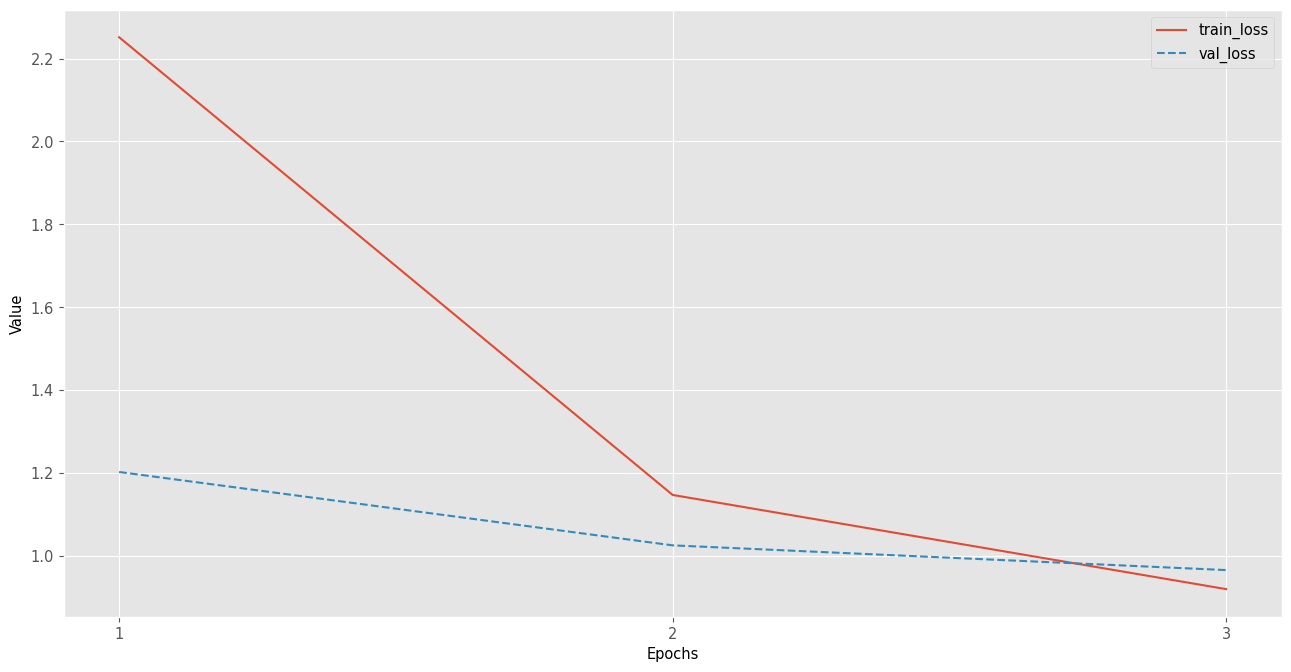

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


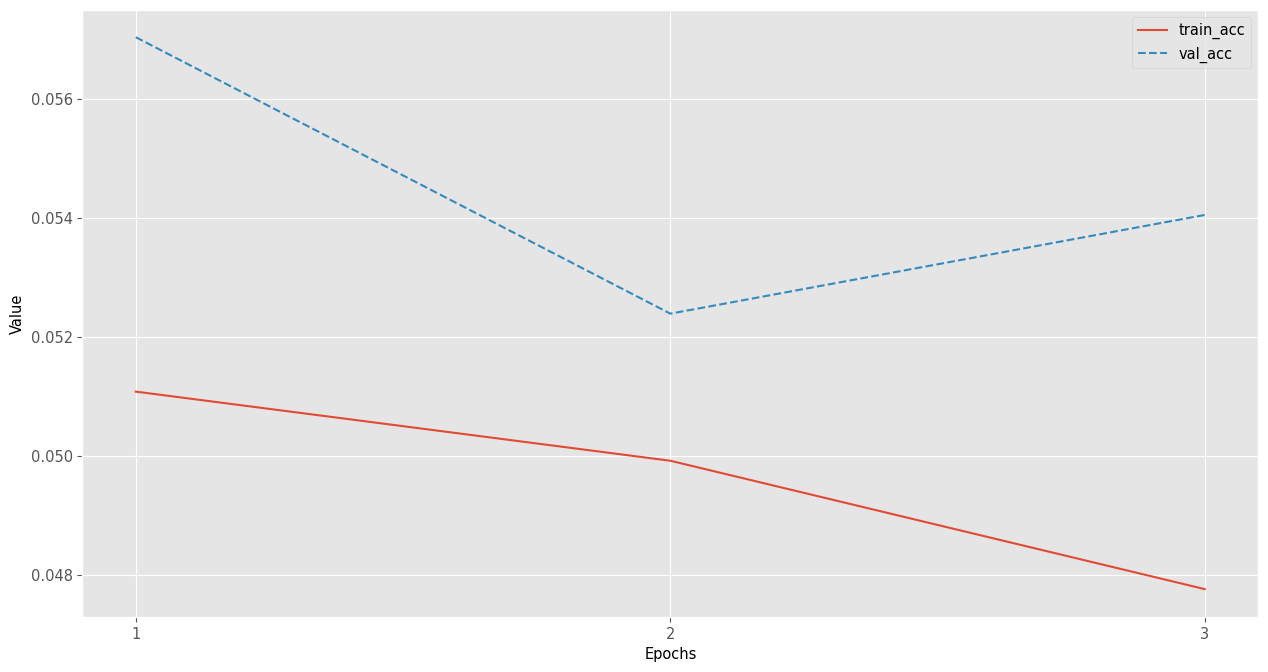

In [56]:
# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [57]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
num_test_steps = 0
test_predictions = []

with torch.no_grad():
  for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    test_loss += loss.item()
    num_test_steps += 1

    logits = outputs.logits
    predictions = logits.argmax(dim=1).cpu().numpy()
    test_predictions.extend(predictions)


avg_test_loss = test_loss / num_test_steps
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy:.2%}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test Loss: 0.9853583450539637, Test Accuracy: 70.05%


In [41]:
# Calculate other metrics
from sklearn.metrics import f1_score, precision_score, recall_score

test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy:.2%}")

Test Precision: 0.5159556992671239
Test Recall: 0.5063660477453581
Test F1 Score: 0.49726138217510896
Test Loss: 1.5995142980147217, Test Accuracy: 50.64%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next section includes model predictions on some random texts

In [58]:
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return target_names[probs.argmax()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
text = """
The first thing is first.
If you purchase a Macbook, you should not encounter performance issues that will prevent you from learning to code efficiently.
However, in the off chance that you have to deal with a slow computer, you will need to make some adjustments.
Having too many background apps running in the background is one of the most common causes.
The same can be said about a lack of drive storage.
For that, it helps if you uninstall xcode and other unnecessary applications, as well as temporary system junk like caches and old backups.
"""
print(get_prediction(text))

comp.sys.mac.hardware


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
text = """
A black hole is a place in space where gravity pulls so much that even light can not get out.
The gravity is so strong because matter has been squeezed into a tiny space. This can happen when a star is dying.
Because no light can get out, people can't see black holes.
They are invisible. Space telescopes with special tools can help find black holes.
The special tools can see how stars that are very close to black holes act differently than other stars.
"""
print(get_prediction(text))

sci.space


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
